In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
import pickle

In [11]:


# ✅ Step 1: Set Up Data Generators
train_dir = "C:\\Users\\manoj\\anaconda3\\Tumor\\dataset\\Training"  # Update with your dataset path
val_dir = "C:\\Users\\manoj\\anaconda3\\Tumor\\dataset\\Testing"  # Update with your dataset path
test_dir = "C:\\Users\\manoj\\anaconda3\\Tumor\\dataset\\Testing"  # Update with your dataset path

batch_size = 32
img_size = (224, 224)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # One-hot encoding
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=1,  # Batch size 1 for individual prediction
    class_mode='categorical',
    shuffle=False
)


Found 2227 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [13]:

Labels = ['glioma','meningioma','pituitary','notumor']
img_size=224
def get_data(dataset):
    data=[]
    for label in Labels:
        path=os.path.join(dataset,label)
        db_class=Labels.index(label)
        print(db_class)
        i=1
        for img in os.listdir(path):
            try:
                arr_img=cv2.imread(os.path.join(path,img))
                im=arr_img;

                arr_resized=cv2.resize(im,(img_size,img_size))
                if im is None:
                    print('hoooi')
                i=i+1

                data.append([arr_resized, db_class])



            except Exception as e:
                print(e)
                continue



    return (np.array(data, dtype=object))


In [19]:
datadir = "C:\\Users\\manoj\\anaconda3\\Tumor\\dataset\\Training"

train = get_data(datadir)

0
1
2
3


<Axes: xlabel='count'>

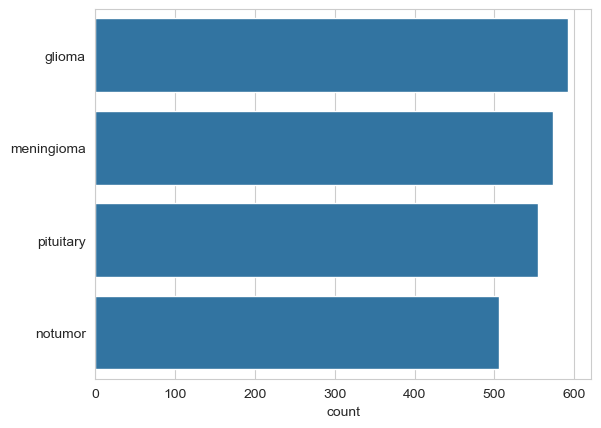

In [21]:
l=[]
for i in train:
  if (i[1]==0):
    l.append('glioma')
  elif(i[1] == 1):
    l.append("meningioma")
  elif(i[1] == 2):
    l.append("pituitary")
  else:
     l.append("notumor")
sns.set_style('whitegrid')
sns.countplot(l)

294930


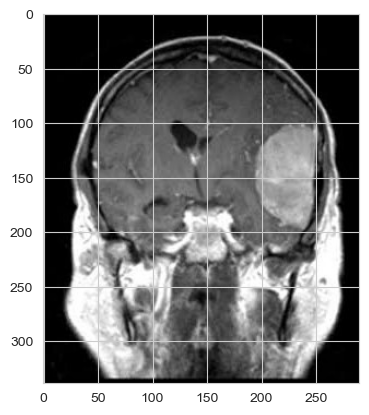

In [27]:
img_data = []
img_size=224
path ="C:\\Users\\manoj\\anaconda3\\Tumor\\dataset\\Testing\\meningioma\\Te-me_0016.jpg"
#C:\Users\albin\anaconda3\Tumor\dataset\Testing\meningioma
arr_img=cv2.imread(path)
try:
                spo= path.find('-')
                arr_img=cv2.imread(path)
                im=arr_img;
                plt.imshow(im)
                arr_resized=cv2.resize(im,(img_size,img_size))
                print(arr_img.size)
                epo= path.find('-',spo+1)
                ex=path[spo+1:epo]
                ex=ex[:2]
                if im is None:
                    print('hoooi')
                i=i+1

                img_data.append(arr_resized)


except Exception as e:
      print('ddd')
      print(e)
test_array = np.array(img_data, dtype=object)

In [29]:
from tensorflow.keras.regularizers import l2

In [32]:

# ✅ Step 2: Load Pretrained Model (DenseNet121)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze pretrained layers

# ✅ Step 3: Add Custom Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(len(train_generator.class_indices), activation='softmax')(x)  # Output layer

model = Model(inputs=base_model.input, outputs=output_layer)

# ✅ Step 4: Compile Model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [34]:
def fuse_conv_bn(conv_layer, bn_layer):
    """Fuses a Conv2D layer and BatchNormalization layer into a single Conv2D layer."""
    # Extract convolution weights and biases
    conv_weights = conv_layer.get_weights()[0]  # Shape: (kernel_h, kernel_w, in_channels, out_channels)
    conv_bias = conv_layer.get_weights()[1] if len(conv_layer.get_weights()) > 1 else np.zeros(conv_weights.shape[-1])

    # Extract batch normalization parameters
    bn_gamma, bn_beta, bn_mean, bn_var = bn_layer.get_weights()
    bn_epsilon = bn_layer.epsilon

    # Compute scale and bias correction 
    scale = bn_gamma / np.sqrt(bn_var + bn_epsilon)
    bias = bn_beta - (bn_mean * scale)

    # Update conv weights
    fused_weights = conv_weights * scale.reshape((1, 1, 1, -1))
    fused_bias = conv_bias * scale + bias

    # Create a new Conv2D layer with fused weights
    fused_conv = Conv2D(filters=conv_layer.filters,
                        kernel_size=conv_layer.kernel_size,
                        strides=conv_layer.strides,
                        padding=conv_layer.padding,
                        dilation_rate=conv_layer.dilation_rate,
                        activation=conv_layer.activation,
                        use_bias=True, kernel_regularizer=l2(0.01))  # Bias is needed after fusion
    # regularisation over
    # Set new weights
    input_shape = (1, 224, 224, 3) 
    fused_conv.build(input_shape)  # Build layer with correct shape
    fused_conv.set_weights([fused_weights, fused_bias])

    return fused_conv


In [36]:
def quantise(model):
    quantized_model = tfmot.quantization.keras.quantize_model(model)
    # Compile the quantized model
    return(quantized_model)


In [38]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [42]:
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout, BatchNormalization

In [ ]:


    # Define a Conv2D layer for a 224x224 image with 3 channels (RGB)
    conv = Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(1,224, 224, 3))
#conv = Conv2D(32, (3, 3), padding='same', use_bias=False, input_shape=(224, 224, 3))
    bn = BatchNormalization()
# Fuse layers
    fused_conv = model #fuse_conv_bn(conv, bn)
    
# Print fused layer summary
    # fusing of Convlution Layer and BN -ok 
    # Tuning
    # 1.Output Kenel Regularation
    #2. Quantisation
    # Selef attension 
    
    #q_model= quantise (fused_conv)
    q_model=fused_conv
# ✅ Step 5: Train the Model
epochs = 10
history = q_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,     callbacks=[early_stopping]
)

# ✅ Step 6: Save the Model
#model.save("image_classifier.h5")

pickle.dump(model,open('model_27_02.pkl','wb'))
# ✅ Step 7: Load the Model for Predictions
#loaded_model = keras.models.load_model("image_classifier.h5")
print("Model saved successfully!")


C:\Users\manoj\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - accuracy: 0.3562 - loss: 1.5815 - precision: 0.3972 - recall: 0.2405 - val_accuracy: 0.7376 - val_loss: 0.7250 - val_precision: 0.8490 - val_recall: 0.5706
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6608 - loss: 0.8228 - precision: 0.7169 - recall: 0.5550

In [ ]:

import matplotlib.pyplot as plt

# Extract values from history
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs_range = range(len(train_loss))

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()


# Extract history and plot recall/precision
history_dict = history.history
epochs_range = range(len(history_dict['loss']))

# Get precision and recall
train_precision = history_dict['precision']
val_precision = history_dict['val_precision']
train_recall = history_dict['recall']
val_recall = history_dict['val_recall']

# Plot Precision
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)

In [7]:
#  Check Point to Load Pickel and Get results

In [21]:
loaded_model=pickle.load(open('model_27_02.pkl','rb'))

In [29]:

# ✅ Step 8: Make Predictions
def predict_image(image_path, model, class_labels):
    from tensorflow.keras.preprocessing import image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Expand batch dimension
    
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Get class index
    confidence = np.max(prediction)  # Get confidence score
    
    print(f"Predicted Class: {class_labels[predicted_class]} | Confidence: {confidence:.2f}")
    return(predicted_class)
    # Display image
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_class]}\nConfidence: {confidence:.2f}")
    plt.axis("off")
    #plt.show()

# Get class labels
class_labels = {v: k for k, v in train_generator.class_indices.items()}
print("Class Labels:", class_labels)

# Test Prediction on an Image
path="C:/Users/albin/anaconda3/Tumor/dataset/Testing/glioma"
a1=0
a2=0
a3=0
a4=0
for img in os.listdir(path):
    fname=img
    test_image_path=path+"/"+fname
    #test_image_path = "C:/Users/adels/anaconda31/Tumor/dataset/Testing/pituitary/Te-pi_0011.jpg"  # Update with your test image path
    cls=predict_image(test_image_path, loaded_model, class_labels)
    if ( cls==0):
        a1=a1+1
    if ( cls==1):
        a2=a2+1
    if ( cls==2):
        a3=a3+1
    if ( cls==3):
        a4=a4+1



Class Labels: {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
Predicted Class: glioma | Confidence: 0.93
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
Predicted Class: glioma | Confidence: 0.75
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step
Predicted Class: glioma | Confidence: 0.98
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
Predicted Class: meningioma | Confidence: 0.60
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Predicted Class: pituitary | Confidence: 0.63
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
Predicted Class: meningioma | Confidence: 0.78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
Predicted Class: glioma | Confidence: 0.91
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Predicted Class: glioma | Confidence: 0.96
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step
Predicted Class: glioma | Confidence: 0.87
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Predicted Class: glioma | Confidence: 0.97
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
Predicted Class: pituitary | Confidence: 0.49
1/1 ━━━━━

prediction summary
{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}
230 41 4 25
